### Numerical problem for Problem set #4

### Simulating spiral features in Saturn's rings on the shearing sheet. 

Inspired by this example:

https://github.com/hannorein/rebound/blob/main/ipython_examples/SaturnsRings.ipynb

When their are collisions between pairs of particles, they bounce but energy is lost. 

The simulation domain is doubly periodic but exhibits shear and epicyclic motion.

Your goal is explore or answer one of these questions: 

    a. Particles migrate (drift in radius) because they are affected by the spiral structure.  Do massive particles migrate more quickly or less quickly than lower mass particles?  You can measure the rate that particles tend to move away from their initial x or radial coordinate position. Do particles drift in a particular direction or do they wander back and forth?

    b. Can a massive particle open a gap?  To better see a depression in the disk density you can compute the average density integrating over y, the azimuthal variable, as a function of x, the radial variable. 

When adjusting the mass distribution or surface density, check the particle number. 
You don't want too many particles otherwise your simulation will take a long time. 
I found that it was easier to see a depression in the disk density (a weak gap) in a lower density disk.  I plotted a histogram to see the average density as a function of $x$. 


In [2]:
import rebound
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from rebound import hash as rebound_h
# we need the hash function to id particles if we use the tree gravity and collision detection in rebound 
# the tree code rearranges particle arrays


In [4]:
# some subroutines 

# Compute the coefficient of restitution for a pair of particles bouncing off each other
# as a function of the velocity difference v between the two objects 
# and r the distance between them (at impact)
# units: v  [m/s] and r [m] 
# returns the coefficient of restitution eps 
#   which is probably defined as the ratio of post and pre relative velocity magnitudes  
def cor_bridges(r, v):
    v32 = 0.01 # m/s velocity giving eps = 0.32, to increase damping lower this number 
    eps = 0.32*pow(abs(v)/v32 + 1e-6,-0.234) # high velocity encounters have lower coefficents of restitution
    if eps>1.:  # keep at or below 1
        eps=1.
    if eps<0.01:  
        eps=0.01  # always bounce a little bit
    return eps
    # eps is 0.32 at v = 0.01 m/s, eps is lower than this at higher velocities 
# You could modify this routine, or create an extra similar routine if you want to adjust the dissipation rate 

# return a random variable that is drawn from a probability distribution 
# that is a power-law with probability p propto v^slope
# and lies within [min_v,max_v]
def powerlaw(slope, min_v, max_v):
    y = np.random.uniform()
    pow_max = pow(max_v, slope+1.)
    pow_min = pow(min_v, slope+1.)
    return pow((pow_max-pow_min)*y + pow_min, 1./(slope+1.))

# make a pretty plot of simulation particle positions in x,y plotting circles with their radii  
# This is the same as Hanno Rein's function in the Saturn example, but here x and y are not flipped 
def plotParticles(sim):
    fig = plt.figure(figsize=(8,8))
    ax = plt.subplot(111,aspect='equal')
    ax.set_xlabel("radial coordinate [m]")
    ax.set_ylabel("azimuthal coordinate [m]")
    boxsize = sim.boxsize.x 
    ax.set_ylim(-boxsize/2.,boxsize/2.)
    ax.set_xlim(-boxsize/2.,boxsize/2.)

    for i, p in enumerate(sim.particles):  # loop over particles 
        circ = patches.Circle((p.x, p.y), p.r, facecolor='darkgray', edgecolor='black')
        ax.add_patch(circ)  # plot a circle
        # notice that p.x and p.y were flipped in the plotting routine by Hanno
    
    # plot some arrows 
    ax.arrow( boxsize*0.5*0.9,0,0,-boxsize/4,width=2)  # to show direction of motion 
    ax.arrow(-boxsize*0.5*0.9,0,0, boxsize/4,width=2)

# create an initial distribution of particles 
# the particles are added to the rebound simulation sim
# surface density [kg m^-2] and particle density [kg m^-3] are  the total mass surface density and 
#    the particle mass density
# particles are added until the expected total mass in the box is reached 
# the radius distribution of the particles is a powerlaw of slope = slope
#    min and max radii for this distribution are min_v and max_v in m
# The mass distribution has powerlaw slope of slope/3?
# I modified this routine so each particle is asigned a unique hash number 
# we need to do this if we want to id particles as the tree routine reaaranges the indices 
# To adjust the mass/radius distributions you would vary the max or min radii or slope
def mkparticles(surface_density,particle_density,slope,min_v,max_v,sim):
    boxsize = sim.boxsize.x
    total_mass = 0.
    i=0
    while (total_mass < surface_density*(boxsize**2)):
        radius = powerlaw(slope=slope, min_v=min_v, max_v=max_v)  # [m]    
        mass = particle_density*4./3.*np.pi*(radius**3) # [kg m^-3]
        x = np.random.uniform(low=-boxsize/2., high=boxsize/2.) # a random number in [-boxsize/2,boxside/2]
        sim.add(
            hash = i, m=mass, r=radius,
            x=x,
            y=np.random.uniform(low=-boxsize/2., high=boxsize/2.),
            z=np.random.normal(),
            vx = 0.,
            vy = -3./2.*x*sim.ri_sei.OMEGA,       
            vz = 0.)
        total_mass += mass
        i+= 1
        # you can see shear direction here from how vy depends upon x 
        # particles are begun at zero epicyclic amplitude
        # the shear motion is down on the right (+x) and up on the left (-x)
        # the (unique) hash number is set equal to the index of the loop
        # the z value is a normal distribution with dispersion of 1 m
    print('Number of particles= ',sim.N);

# compute residual (remainder) of x modulo m but in range [-m/2,m/2]
# this routine is useful for keep quantities within the periodic shearing box
def resid(x,m):
    z = (x+ m/2)%m - m/2
    return z


In [6]:
# set up a simulation, saves time if you are setting up more than one simulation
def setup_sim(boxsize):
    # set up a simulation for Saturn's rings
    sim = rebound.Simulation()
    OMEGA = 0.00013143527     # for Saturn's rings at a radius (from center of Saturn) of about 130000 km
    sim.ri_sei.OMEGA = OMEGA  # [s^-1] the angular rotation rate and epicyclic frequency (nearly Keplerian)
    sim.G = 6.67428e-11       # N m^2 / kg^2 (MKS) gravitational constant 
    sim.dt = 1e-3*2.*np.pi/OMEGA   # timestep for integrator 
    sim.softening = 0.2       # [m] prevents spurious large velocity impulses 

    sim.N_ghost_x = 2  # needed for shearing sheet shear boundary condition  
    sim.N_ghost_y = 2
    sim.integrator = "sei"  # simplectic integrator for shearing sheet
    sim.boundary   = "shear" # boundary type
    sim.gravity    = "tree" # is a faster gravity routine but because we use it we need to use a hash function to id particles 
    sim.collision  = "tree" # trees are good at finding collisions!
    sim.collision_resolve = "hardsphere"
    sim.coefficient_of_restitution = cor_bridges # how particles bounce off each other!
    # here we are telling the simulation about the function defined above that gives the coefficient of restitution
    sim.configure_box(boxsize)  # tell the simulation about the box
    return sim  # return the simulation

# integrate the simulation sim to a series of times in the 1d array tlin [s] and store results 
# the arrays xarr,yarr,marr are returned  
# xarr,yarr are x,y positions as in [m] 2d arrays as a function of time and for each particle 
# marr are particle masses in [kg]  a 1 d array (mass for each particle)
def run_sim(sim,tlin):
    Nt = len(tlin) # numbers of times to store integration  
    xarr = np.zeros((Nt,sim.N))  # x positions at different times for different particles 
    yarr = np.zeros((Nt,sim.N))  # y positions 
    marr = np.zeros(sim.N)       # particle masses 
    for i in range(len(tlin)):  # loop over times 
        sim.integrate(tlin[i])  # integrate to this time 
        for j in range(sim.N):  # loop over particles 
            p  = sim.particles[rebound_h(j)] # we need to use a hash to id particles 
            # because the tree code insists upon rearranging particle ids 
            xarr[i,j] = p.x # store x positions 
            yarr[i,j] = p.y # store y positions
            #x_g_arr[i,j] = 4*p.x + (2.0/sim.ri_sei.OMEGA) * p.vy # store guiding radius in x 
    for j in range(sim.N): # store masses 
        p  = sim.particles[rebound_h(j)] 
        marr[j] = p.m
    return xarr,yarr,marr # return stored arrays

# return how far in x each particle drifts as a function of time 
# xarr is the array that is returned by run_sim()
# returns a 2d array (time, particle) 
def compute_dx(xarr,sim):
    boxsize = sim.boxsize.x
    Nt = xarr.shape[0]
    N  = xarr.shape[1]
    delta_x = np.zeros((Nt,N))
    for j in range(N):  # loop over particles 
        delta_x[:,j] = resid(xarr[:,j]- xarr[0,j],boxsize)
    return delta_x

Number of particles=  2185


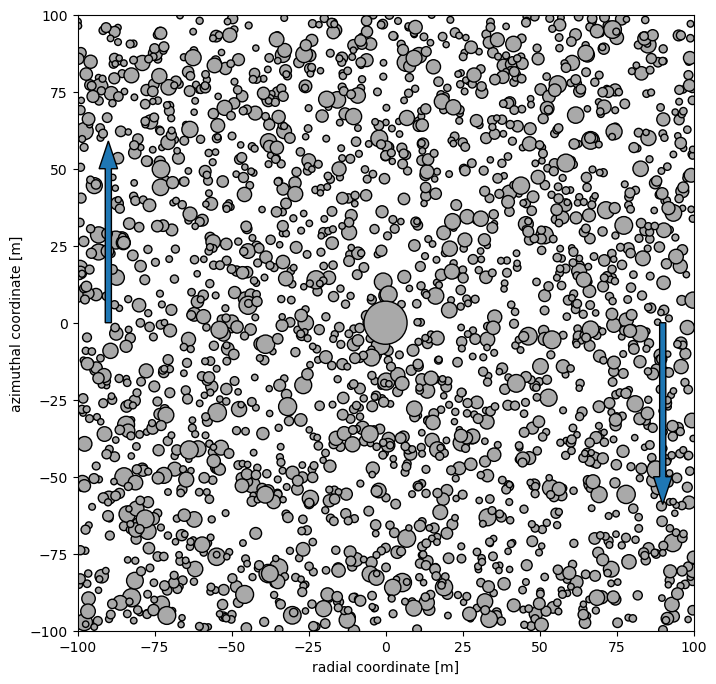

In [8]:
# let's look at a simulation! 
boxsize = 200.            # [m]
sim_a = setup_sim(boxsize) # give me a simulation!

#parameters used in creating the distribution of particles 
surface_density  = 400.   # [kg/m^2], change this if you are exploring option f.
particle_density = 400.   # [kg/m^3]
slope = -3.0 # the slope of the particle's radius distribution 
min_v = 1.0  # minimum particle radius in m
max_v = 3.0  # maximum radius in m

# create a distribution of particles in simulation
mkparticles(surface_density,particle_density,slope,min_v,max_v,sim_a) 

# add an extra more massive particle, relevant if you are exploring options c or d 
radius = 7.  # make a larger mass particle and put it in the center 
mass = particle_density*4./3.*np.pi*(radius**3) # particle mass 
sim_a.add(m=mass,r = radius,x=0,y=0,z=0,vx=0,vy=0,vz=0,hash = (sim_a.N)) # note hash!
plotParticles(sim_a) # show the initial conditions 

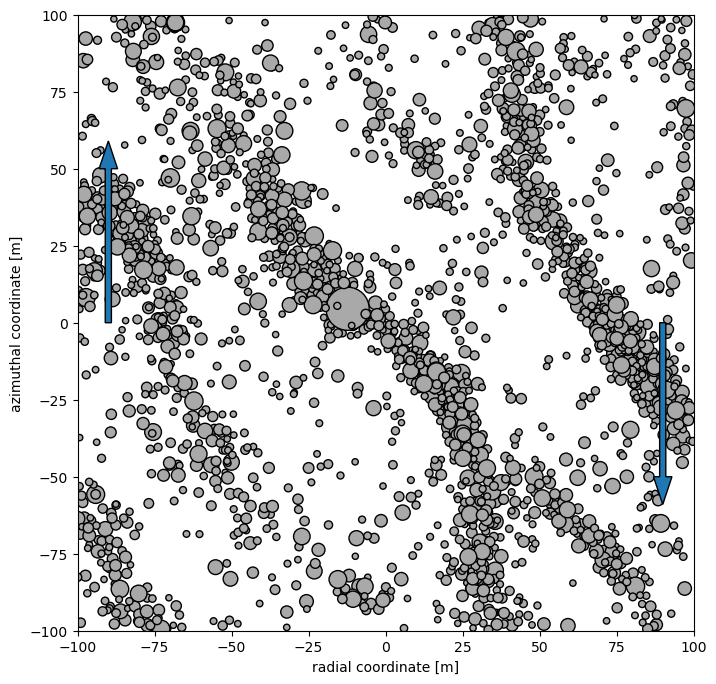

In [9]:
tlin_a = np.linspace(0,4*np.pi/sim_a.ri_sei.OMEGA,100) # create an array of 100 times out to 4 pi/Omega
xarr_a,yarr_a,marr_a = run_sim(sim_a,tlin_a) # run the simulation and return x,y,m arrays 
deltax_a = compute_dx(xarr_a,sim_a)
plotParticles(sim_a)

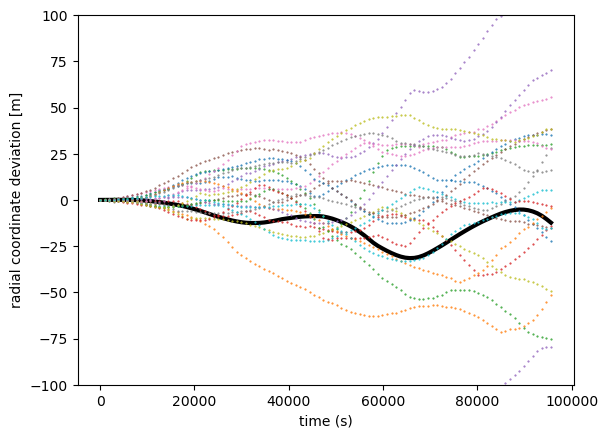

In [10]:
# plot how x (the radial coordinate) relative to initial value varies in time for a few particles 
fig,ax = plt.subplots(1,1)
ax.set_xlabel('time (s)')
ax.set_ylabel('radial coordinate deviation [m]')
boxsize = sim_a.boxsize.x
ax.set_ylim([-boxsize/2,boxsize/2])
i = sim_a.N-1 # the last particle we added to the simulation which was larger than the rest 
ax.plot(tlin_a, deltax_a[:,i],'k-',lw=3) # show how far the last (massive) particle moves as a function of time 
#plot a few other particles and show how far they went in the radial coordinate 
for j in range(0,20):
    ax.plot(tlin_a, deltax_a[:,j],'.',ms=1)

This shows that the x coordinates of each particle diverges from their initial value. 